In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import pydot
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers
from sklearn.utils import resample
from scipy import stats
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

tf.random.set_seed(42)

2024-02-13 09:07:38.816189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 09:07:38.816299: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 09:07:38.939164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/mhealth-raw-data/mhealth_raw_data.csv')


In [3]:
df.shape

(1215745, 14)

In [4]:
df.head(10)

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1
5,2.2639,-9.4493,0.61267,0.098330,-0.84240,-0.68959,-8.7247,-4.0449,0.506090,-0.45686,-1.0082,0.025862,0,subject1
6,2.1740,-9.6574,0.60137,0.098330,-0.84240,-0.68959,-9.0864,-4.1474,0.261380,-0.42745,-1.0164,0.019397,0,subject1
7,2.2023,-9.4397,0.58129,0.098330,-0.84240,-0.68959,-9.0143,-4.0052,0.476820,-0.42745,-1.0164,0.019397,0,subject1
8,2.2037,-9.6283,0.54062,0.076067,-0.83114,-0.69155,-9.0469,-4.0475,0.245540,-0.42745,-1.0164,0.019397,0,subject1
9,2.2135,-9.6887,0.43353,0.076067,-0.83114,-0.69155,-8.8318,-4.1090,0.096632,-0.42745,-1.0164,0.019397,0,subject1


<Axes: >

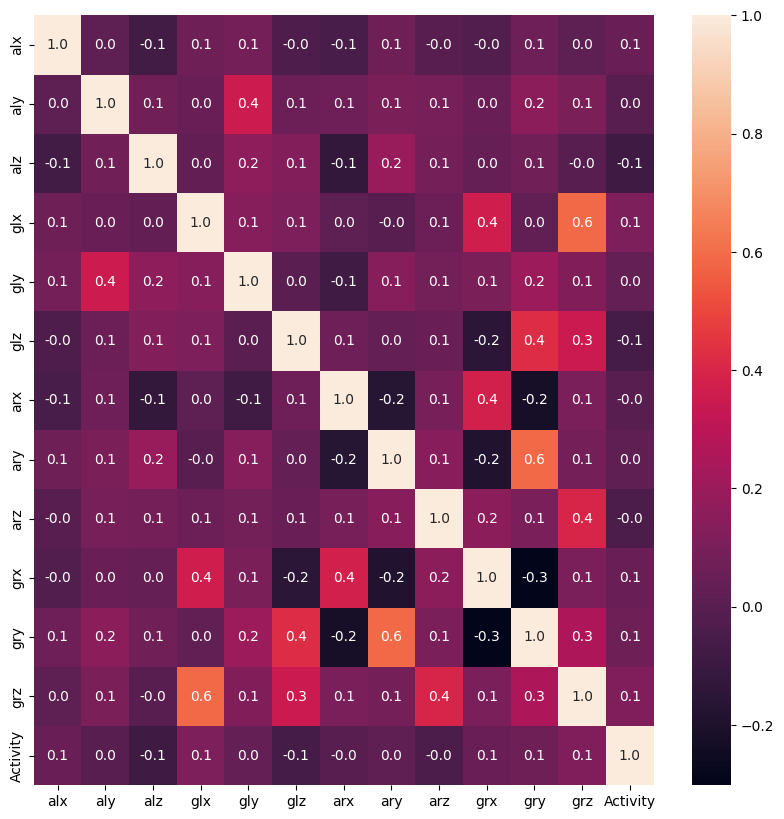

In [5]:
numeric_df = df.select_dtypes(include=['number'])
corr = numeric_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt='.1f')

In [6]:
#Data Cleaning
df['Activity'].value_counts()

Activity
0     872550
1      30720
2      30720
3      30720
4      30720
9      30720
5      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64

In [7]:
#Downsample majority class for getting balanced dataset
df_major = df[df['Activity'] == 0]
df_minor = df[df['Activity'] != 0]
df_major_down = resample(df_major, n_samples = 30000, random_state = 42)
df = pd.concat([df_major_down, df_minor])
print('Resampled dataset: ')
print(df['Activity'].value_counts())

Resampled dataset: 
Activity
1     30720
3     30720
2     30720
4     30720
9     30720
11    30720
5     30720
10    30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: count, dtype: int64


In [8]:
df1 = df.copy()
for feature in df1.columns[:-2]:
  low_range = np.quantile(df[feature], 0.01)
  up_range = np.quantile(df[feature], 0.99)
  print(feature, 'range: ', low_range, 'to', up_range)

  df1 = df1.drop(df1[(df1[feature] > up_range) | (df1[feature] < low_range)].index, axis = 0)
  print('Shape', df1.shape)

alx range:  -11.47312 to 19.233
Shape (365733, 14)
aly range:  -19.379 to 2.447871999999997
Shape (360018, 14)
alz range:  -18.95 to 14.19623999999999
Shape (356270, 14)
glx range:  -0.74212 to 0.80705
Shape (349377, 14)
gly range:  -1.0694 to 0.96623
Shape (342841, 14)
glz range:  -1.1061 to 0.8290799999999999
Shape (337391, 14)
arx range:  -21.492 to 9.097647999999998
Shape (332307, 14)
ary range:  -18.694000000000003 to 11.948059999999998
Shape (326241, 14)
arz range:  -10.367 to 11.823119999999996
Shape (323674, 14)
grx range:  -1.0196 to 0.95686
Shape (320188, 14)
gry range:  -1.1417 to 0.90965
Shape (315352, 14)
grz range:  -0.69828 to 1.125
Shape (310929, 14)


In [9]:
#Mapping
label_map = {
    0: 'Nothing',
    1: 'Standing still',
    2: 'Sitting and relaxing',
    3: 'Lying down',
    4: 'Walking',
    5: 'Climbing stairs',
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms',
    8: 'Knees beending',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jump front and back'
}

In [10]:
df1.shape

(310929, 14)

In [11]:
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis = 0)

In [12]:
train.shape

(246501, 14)

In [13]:
test.shape

(64428, 14)

In [14]:
X_train = train.drop(['Activity', 'subject'], axis = 1)
y_train = train['Activity']
X_test = test.drop(['Activity', 'subject'], axis = 1)
y_test = test['Activity']


In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(246501, 12) (246501,) (64428, 12) (64428,)


In [16]:
def create_dataset(X, y, time_steps, step = 1):
  Xs, ys = [], []
  for i in range(0, len(X) -time_steps, step):
    x = X.iloc[i:(i + time_steps)].values
    labels = y.iloc[i:i + time_steps].values
    unique_labels = np.unique(labels)
    if len(unique_labels) == 1:
      mode_label = unique_labels[0]
    else:
      mode_label = stats.mode(labels)[0]
      if isinstance(mode_label, np.ndarray):
        mode_label = mode_label[0]
    Xs.append(x)
    ys.append(mode_label)
  return np.array(Xs), np.array(ys).reshape(-1,1)


In [17]:
X_train, y_train = create_dataset(X_train, y_train, 100, step = 50)
print(X_train.shape, y_train.shape)

(4929, 100, 12) (4929, 1)


In [18]:
X_test, y_test = create_dataset(X_test, y_test, 100, step = 50)
print(X_test.shape, y_test.shape)

(1287, 100, 12) (1287, 1)


In [19]:
inputs = layers.Input(shape=[100,12] , name = 'inputs')

# First convolutional layer
conv_layer = layers.Conv1D(filters=16, kernel_size=3, padding="same")(inputs)

# Batch normalization
bn1 = layers.BatchNormalization()(conv_layer)
drl1 = layers.Dropout(0.2)(bn1)

# LSTM layer with 64 units with attention layer
lstm1 = layers.LSTM(64,return_sequences=True)
query_features = lstm1(drl1)
value_features = lstm1(drl1)
attention1 = layers.Attention()([query_features,value_features]) # for calculating attention scores to assign weights to the next LSTM layer

# expanding into two separate branches

# Branch 1
lstm2 = layers.LSTM(64)(attention1)

# Branch 2
dl2 = layers.Dense(units = 64, activation='relu')(lstm2)
bn2 = layers.BatchNormalization()(dl2)
drl2 = layers.Dropout(0.2)(bn2) 


# Merging the two branches
concatenated = layers.concatenate([lstm2,drl2]) 

# Another dense layer with 64 units
dl2 = layers.Dense(units = 64, activation = 'relu')(concatenated)
# using softmax activation to get probablity of each label for multi-class classification
outputs = layers.Dense(units = 13, activation='softmax')(dl2)

In [20]:
# Create the model
model = Model(inputs=inputs, outputs=outputs)

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, 100, 12)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 100, 16)              592       ['inputs[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 100, 16)              64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 dropout (Dropout)           (None, 100, 16)              0         ['batch_normalization[0][0

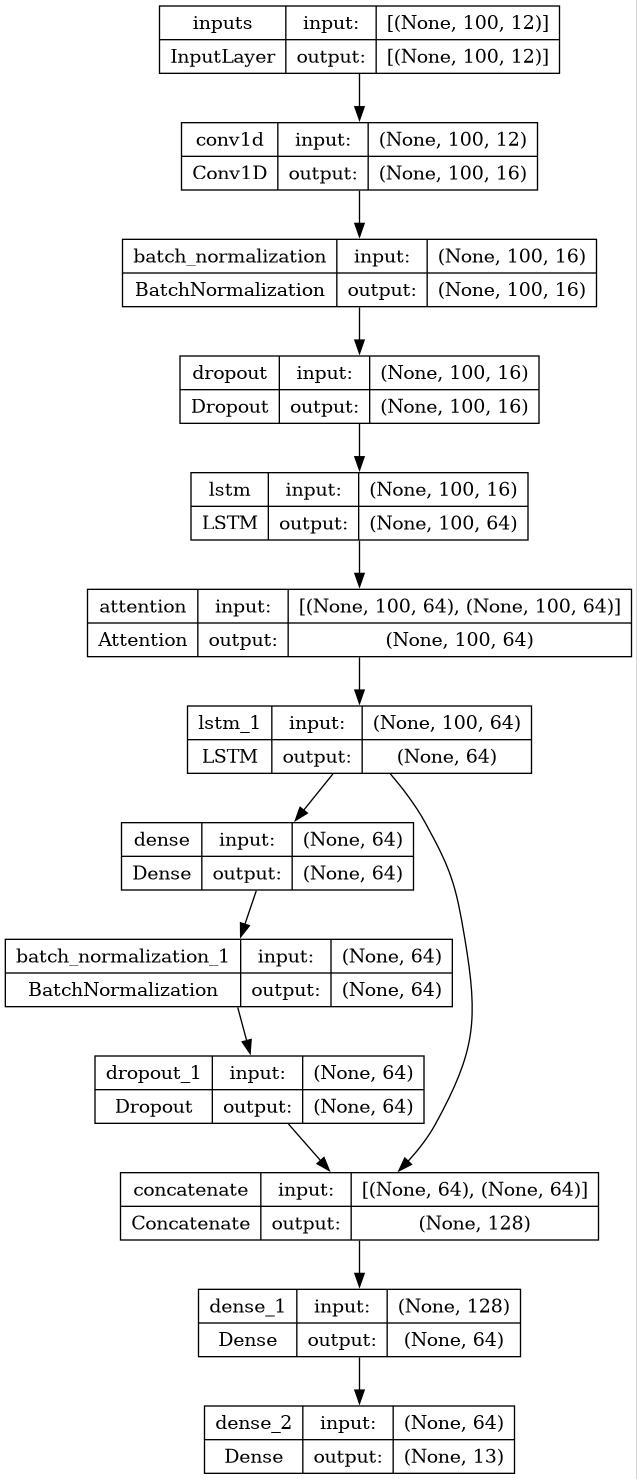

In [23]:
tf.keras.utils.plot_model(model, show_shapes = True, to_file = 'model.jpg')

In [24]:
callbacks = [keras.callbacks.ModelCheckpoint("best.h5", save_best_only = True, monitor = "val_loss"),
             keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 50, verbose = 1)]
model_history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test), callbacks = callbacks)

Epoch 1/50


W0000 00:00:1707815284.832683      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16274030592 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
I0000 00:00:1707815287.870569      97 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/155 [==============================] - ETA: 0s - loss: 0.8166 - sparse_categorical_accuracy: 0.7559

W0000 00:00:1707815293.787260      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16274030592 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


155/155 [==============================] - 14s 33ms/step - loss: 0.8166 - sparse_categorical_accuracy: 0.7559 - val_loss: 1.3360 - val_sparse_categorical_accuracy: 0.5330
Epoch 2/50
  4/155 [..............................] - ETA: 3s - loss: 0.3481 - sparse_categorical_accuracy: 0.8984

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


155/155 [==============================] - 4s 23ms/step - loss: 0.2461 - sparse_categorical_accuracy: 0.9290 - val_loss: 0.2186 - val_sparse_categorical_accuracy: 0.9402
Epoch 3/50
155/155 [==============================] - 4s 23ms/step - loss: 0.1689 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.3146 - val_sparse_categorical_accuracy: 0.9145
Epoch 4/50
155/155 [==============================] - 4s 23ms/step - loss: 0.1366 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.0770 - val_sparse_categorical_accuracy: 0.9814
Epoch 5/50
155/155 [==============================] - 4s 24ms/step - loss: 0.1362 - sparse_categorical_accuracy: 0.9625 - val_loss: 0.5096 - val_sparse_categorical_accuracy: 0.9083
Epoch 6/50
155/155 [==============================] - 4s 24ms/step - loss: 0.1035 - sparse_categorical_accuracy: 0.9748 - val_loss: 0.6736 - val_sparse_categorical_accuracy: 0.9060
Epoch 7/50
155/155 [==============================] - 4s 24ms/step - loss: 0.0941 - sparse_categorical_acc

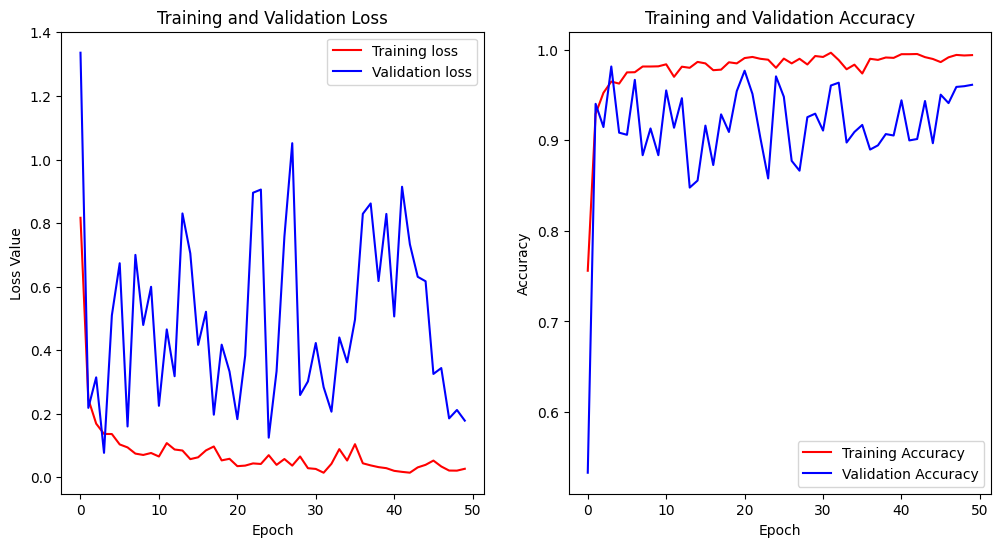

In [25]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_accuracy = model_history.history['sparse_categorical_accuracy']
val_accuracy = model_history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
model = keras.models.load_model('best.h5')

train_loss, train_acc = model.evaluate(X_train,y_train)
test_loss, test_acc = model.evaluate(X_test,y_test)

  1/155 [..............................] - ETA: 2:40 - loss: 0.0027 - sparse_categorical_accuracy: 1.0000

W0000 00:00:1707815465.219033      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16274030592 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


41/41 [==============================] - 0s 8ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9814


In [27]:
print("Train accuracy", round(train_acc*100, 2),'%')
print("Train loss", train_loss)
print("Test accuracy", round(test_acc*100, 2),'%')
print("Test loss", test_loss)

Train accuracy 97.48 %
Train loss 0.09637662023305893
Test accuracy 98.14 %
Test loss 0.0769788920879364


In [28]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 1) # we are essentially getting what the model predicted out of the 13 possible labels
pred = pred.reshape(-1,1)
print(pred.shape,y_test.shape)

 1/41 [..............................] - ETA: 40s

W0000 00:00:1707815468.289400      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla P100-PCIE-16GB" frequency: 1328 num_cores: 56 environment { key: "architecture" value: "6.0" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 16274030592 bandwidth: 732160000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


41/41 [==============================] - 1s 7ms/step
(1287, 1) (1287, 1)


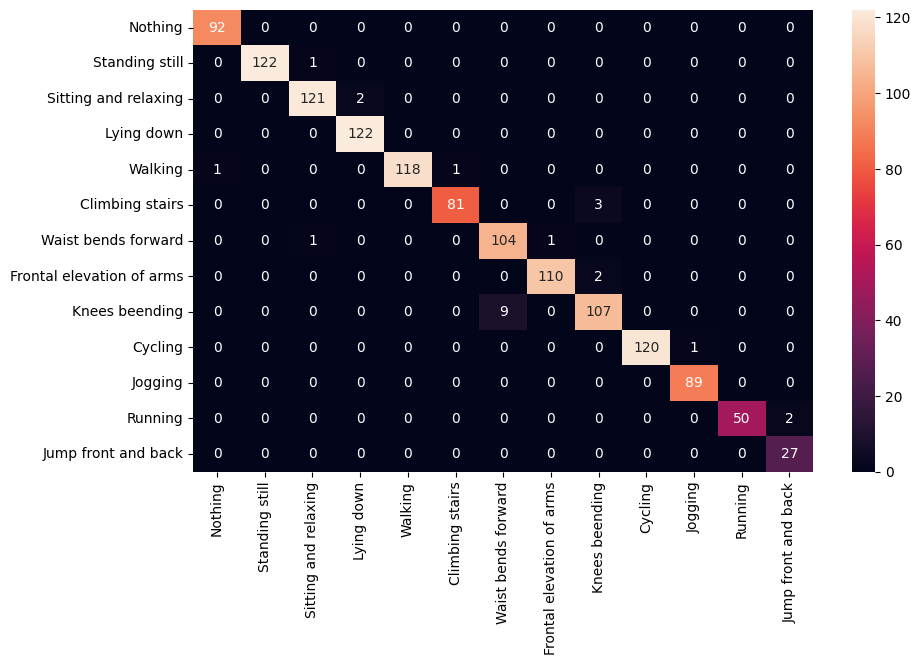

In [29]:
plt.figure(figsize=(10,6))
conf_matrix = confusion_matrix(y_test,pred)
sns.heatmap(conf_matrix, xticklabels= label_map.values(), yticklabels= label_map.values(), annot=True, fmt="d")
plt.show()

In [30]:
print(classification_report(y_test,pred))
print('*'*50)
print(confusion_matrix(y_test,pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        92
           1       1.00      0.99      1.00       123
           2       0.98      0.98      0.98       123
           3       0.98      1.00      0.99       122
           4       1.00      0.98      0.99       120
           5       0.99      0.96      0.98        84
           6       0.92      0.98      0.95       106
           7       0.99      0.98      0.99       112
           8       0.96      0.92      0.94       116
           9       1.00      0.99      1.00       121
          10       0.99      1.00      0.99        89
          11       1.00      0.96      0.98        52
          12       0.93      1.00      0.96        27

    accuracy                           0.98      1287
   macro avg       0.98      0.98      0.98      1287
weighted avg       0.98      0.98      0.98      1287

**************************************************
[[ 92   0   0   0   0   0   